In [4]:
import numpy as np
import pandas as pd
from numpy.random import uniform, normal, chisquare
from math import pi
from scipy.optimize import Bounds
from scipy.optimize import minimize
import matplotlib.pyplot as plt 

# ignore the warning message
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
# k: the number of studies
k_list = [10,30,50,100]
# each element of `parameter_constellation` has the form (mu, sigma^2,tau^2) 
# where tau^2 is the between-study variance, sigma^2 is the within-study variance
parameter_constellation = [(0,12,4),(0,9,4),(0,4,4),(0,2,6)]
# heterogeniety measure: J^2
J_square_list = [element[2]/(element[2]+element[1]) for element in parameter_constellation]
print(J_square_list)

[0.25, 0.3076923076923077, 0.5, 0.75]


## when sigma^2 is known

### The log-likelihood function of $v = (\mu, \sigma^2, \tau^2)$ is given by

$I(v) = \frac{1}{2}\sum \limits_{i=1}^{k}[\frac{(D_i-\mu)^2}{\tau^2+\sigma^2 u_i}+\log{(\tau^2+\sigma^2 u_i)}+c]$

with first order derivatives (only two variables $\mu$ and $\tau^2$)
$$\frac{\partial l(v)}{\partial \mu} = \sum \limits_{i=1}^{k} \frac{D_i - \mu}{\tau^2 + \sigma^2 u_i}$$
$$\frac{\partial l(v)}{\partial \tau^2} = \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2 u_i}$$

Therefore, the Hessian of the log-likelihood function is
$$
\left[\begin{array}{cc} 
\sum \limits_{i=1}^{k} \frac{1}{\tau^2 + \sigma^2 u_i} & 0\\ 
0 & \frac{1}{2} \sum \limits_{i=1}^{k} \frac{1}{(\tau^2 + \sigma^2 u_i)^2}
\end{array}\right]
$$

And 
$$\frac{\partial l(v)}{\partial \mu} = 0 \Rightarrow \mu = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{\tau^2 + \sigma^2 u_i}}{\sum \limits_{i=1}^{k} \frac{1}{\tau^2 + \sigma^2 u_i}} (\text{where } \tau^2 \text{ is unknown})$$ 
$$\frac{\partial l(v)}{\partial \tau^2} = 0 \Rightarrow \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} = \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2 u_i} = \sum \limits_{i=1}^{k} \frac{\tau^2+\sigma^2 u_i}{(\tau^2+\sigma^2 u_i)^2}$$
$$\Rightarrow \tau^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2 - \sigma^2 u_i}{(\tau^2 + \sigma^2 u_i)^2}}{\sum \limits_{i=1}^{k} \frac{1}{(\tau^2 + \sigma^2 u_i)^2}} (\text{where } \tau^2 \text{ is unknown})$$

### remember to fix the half of n=n_max and the remaining half of n=n_min
$$eg, n_{\min} = 10, n_{\max} = 1000$$
Instead of generating n = 1/u from uniform(0.01,0.1)

In [6]:
# function for generating u_array and D_array
def array_generator(k,params,n_min = 10,n_max=100):
    # generate half of n at min and the remaining half of n at max
    # to get rid of randomness
    mu, sigma_square, tau_square = params
    sigma, tau = np.sqrt(sigma_square), np.sqrt(tau_square)
    half_k = int(k/2)
    n_array = np.array([n_min]*half_k + [n_max]*half_k)
    u_array = 1/n_array
    # x_i ~ N(mu,tau^2)
    xi_array = normal(mu,tau,k)
    # D_i ~ N(x_i, sigma^2*u_i)
    D_array = normal(xi_array,sigma*(u_array**0.5),k)
    return u_array, D_array, xi_array

In [7]:
# fix the simulated u_array and D_array in advance
# for avoiding randomness
params = (0,12,4)
two_generated_arrays = array_generator(k=100,params=params)
u_array = two_generated_arrays[0]
D_array = two_generated_arrays[1]
xi_array = two_generated_arrays[2]

### method 1: unconstrained optimization: minimize the negative log-likelihood function with BFGS method (using sigma/tau)

In [8]:
def nll_unknown_sigma(x, D, u, xi):
    # x = np.array([mu, sigma, tau])
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    return 1/2*np.mean((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*pi))

def jac_unknown_sigma(x, D, u, xi):
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_sigma = (np.sum((a**2 * u) / b**2) - np.sum(u / b)) * (2*sigma) 
    d_tau = (np.sum(a**2 / b**2) - np.sum(1./ b)) * (2*tau)
    return - np.array([d_mu, d_sigma, d_tau])


def nll_known_sigma(x, D, u, xi, known_sigma_square):
    # x = np.array([mu, tau])
    mu, tau = x[0], x[1]
    tau_square = tau**2
    return 1/2*np.mean((D - mu)**2/(tau_square + known_sigma_square*u) \
            +np.log(tau_square + known_sigma_square*u)+np.log(2*pi))


def jac_known_sigma(x, D, u, xi, known_sigma_square):
    mu, tau = x[0], x[1]
    tau_square = tau**2

    a = D - mu
    b = tau_square + known_sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_tau = (np.sum(a**2 / b**2) - np.sum(1./ b)) * (2*tau)
    return - np.array([d_mu, d_tau])


In [9]:
def simulation_UC_unknown_sigma(D_array, u_array, xi_array, params, stopping_criteria = 1e-10):
    
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    sigma_square_0 = uniform(0,15)
    sigma_0 = np.sqrt(sigma_square_0)
    
    x0 = np.array([mu_0, sigma_0, tau_0])
    minimizer = minimize(nll_unknown_sigma, x0, args=(D_array, u_array, xi_array), method="BFGS", jac=jac_unknown_sigma, tol=stopping_criteria)   
    
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    mu_ast, sigma_ast, tau_ast = minimizer.x
    n_iteration = minimizer.nit
    sigma_square_ast = sigma_ast**2
    tau_square_ast = tau_ast**2
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [10]:
simulation_UC_unknown_sigma(D_array, u_array, xi_array, params, stopping_criteria = 1e-10)

array([9.40158020e-04, 3.34979147e+00, 6.40000000e+01])

In [11]:
def simulation_UC_known_sigma(D_array,u_array, xi_array, params, stopping_criteria = 1e-10):
    
    # random but resonable initial point
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    known_sigma_square = params[1]
    
    x0 = np.array([mu_0, tau_0])
    minimizer = minimize(nll_known_sigma, x0, args=(D_array, u_array, xi_array, known_sigma_square), method="BFGS", jac=jac_known_sigma, tol=stopping_criteria)   
    
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    mu_ast, tau_ast = minimizer.x
    n_iteration = minimizer.nit
    tau_square_ast = tau_ast**2
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [12]:
simulation_UC_known_sigma(D_array,u_array, xi_array, params, stopping_criteria = 1e-10)

array([4.70526914e-03, 3.24106904e+00, 5.80000000e+01])

In [13]:
def simulation_UC_known_sigma_chi(D_array,u_array,xi_array, params, stopping_criteria = 1e-10):
    
    # random but resonable initial point
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    # Sigma^2 is sampled from the scaled chi square distribution
    # S^2/sigma^2 ~ chi^2_{df=k-1}/(k-1)
    k = D_array.shape[0]
    S_sigma_square_ratio = chisquare(df = k-1, size=None)/(k-1)
    known_sigma_square = S_sigma_square_ratio*params[1]
    
    x0 = np.array([mu_0, tau_0])
    minimizer = minimize(nll_known_sigma, x0, args=(D_array, u_array, xi_array, known_sigma_square), method="BFGS", jac=jac_known_sigma, tol=stopping_criteria)   
    
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    mu_ast, tau_ast = minimizer.x
    n_iteration = minimizer.nit
    tau_square_ast = tau_ast**2
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [14]:
simulation_UC_known_sigma_chi(D_array,u_array,xi_array, params, stopping_criteria = 1e-10)

array([6.43367030e-03, 3.19404803e+00, 7.30000000e+01])

### method 2: using softplus function to ensure $\sigma^2/\tau^2$ is positive

In [15]:
# softplus: y = log(e^x + 1)
def softplus(x):
    return np.log(np.exp(x) + 1.0)

# derivative of softplus: dy/dx = e^x/(e^x + 1) = 1 - 1/(e^x + 1)
def d_softplus(x):
    return 1. - 1./(np.exp(x) + 1.0)

def SP_nll_unknown_sigma(x, D, u, xi_array):
    # x = np.array([mu, sigma_square, tau_square])
    mu, sigma_square, tau_square = x[0], softplus(x[1]), softplus(x[2])
    return 1/2*np.mean((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*np.pi))  

# Jacobian: the matrix of all its first-order partial derivatives
def SP_jac_unknown_sigma(x, D, u, xi_array):
    mu, sigma_square, tau_square = x[0], softplus(x[1]), softplus(x[2])
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.mean(a / b)
    d_sigma_square = np.mean((a**2 * u) / b**2) - np.mean(u / b)
    d_tau_square = np.mean(a**2 / b**2) - np.mean(1./ b)
    d0 = d_mu
    d1 = d_sigma_square * d_softplus(x[1])
    d2 = d_tau_square * d_softplus(x[2])
    return - np.array([d0, d1, d2]) 

def SP_nll_known_sigma(x, D, u, xi_array, known_sigma_square):
    # x = np.array([mu, sigma_square, tau_square])
    mu, tau_square = x[0], softplus(x[1])
    return 1/2*np.mean((D - mu)**2/(tau_square + known_sigma_square*u) \
            +np.log(tau_square + known_sigma_square*u)+np.log(2*np.pi))  

# Jacobian: the matrix of all its first-order partial derivatives
def SP_jac_known_sigma(x, D, u, xi_array, known_sigma_square):
    mu, tau_square = x[0], softplus(x[1])

    a = D - mu
    b = tau_square + known_sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.mean(a / b)
    d_tau_square = np.mean(a**2 / b**2) - np.mean(1./ b)
    d0 = d_mu
    d2 = d_tau_square * d_softplus(x[1])
    return - np.array([d0, d2]) 


In [16]:
def simulation_SP_unknown_sigma(D_array,u_array, xi_array, params, stopping_criteria = 1e-10):
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    sigma_square_0 = uniform(0,15)
    sigma_0 = np.sqrt(sigma_square_0)
    
    x0 = np.array([mu_0, sigma_square_0, tau_square_0])
    minimizer = minimize(SP_nll_unknown_sigma, x0, args=(D_array, u_array, xi_array), method="BFGS", jac=SP_jac_unknown_sigma, tol=stopping_criteria)   
    
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    params = minimizer.x
    mu_ast, sigma_square_ast, tau_square_ast = params[0], softplus(params[1]), softplus(params[2])
    n_iteration = minimizer.nit

    return np.array([mu_ast, tau_square_ast, n_iteration])

In [17]:
simulation_SP_unknown_sigma(D_array, u_array, xi_array, params, stopping_criteria = 1e-10)

array([9.40183072e-04, 3.34979083e+00, 2.80000000e+01])

In [18]:
def simulation_SP_known_sigma(D_array,u_array, xi_array, params, stopping_criteria = 1e-10):
    
    # random but resonable initial point
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    known_sigma_square = params[1]
    
    x0 = np.array([mu_0, tau_square_0])
    minimizer = minimize(SP_nll_known_sigma, x0, args=(D_array, u_array, xi_array, known_sigma_square), method="BFGS", jac=SP_jac_known_sigma, tol=stopping_criteria)   
    
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    params = minimizer.x
    mu_ast, tau_square_ast = params[0], softplus(params[1])
    n_iteration = minimizer.nit

    return np.array([mu_ast, tau_square_ast, n_iteration])

In [19]:
simulation_SP_known_sigma(D_array,u_array, xi_array, params, stopping_criteria = 1e-10)

array([4.70521576e-03, 3.24107026e+00, 1.10000000e+01])

In [20]:
def simulation_SP_known_sigma_chi(D_array,u_array,xi_array,params,stopping_criteria = 1e-10):
    
    # random but resonable initial point
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    # Sigma^2 is sampled from the scaled chi square distribution
    # S^2/sigma^2 ~ chi^2_{df=k-1}/(k-1)
    k = D_array.shape[0]
    S_sigma_square_ratio = chisquare(df = k-1, size=None)/(k-1)
    known_sigma_square = S_sigma_square_ratio*params[1]
    
    x0 = np.array([mu_0, tau_square_0])
    minimizer = minimize(SP_nll_known_sigma, x0, args=(D_array, u_array, xi_array, known_sigma_square), method="BFGS", jac=SP_jac_known_sigma, tol=stopping_criteria)   
    
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    params = minimizer.x
    mu_ast, tau_square_ast = params[0], softplus(params[1])
    n_iteration = minimizer.nit

    return np.array([mu_ast, tau_square_ast, n_iteration])

In [21]:
simulation_SP_known_sigma_chi(D_array,u_array,xi_array,params,stopping_criteria = 1e-10)

array([4.08098366e-03, 3.25848501e+00, 1.20000000e+01])

### method 3: constrained (bounded) optimization using tau^2 and sigma^2 (non-negative) with BFGS method

In [22]:
def CO_nll_unknown_sigma(x, D, u, xi_array):
    # x = np.array([mu, sigma^2, tau^2])
    mu, sigma_square, tau_square = x[0], x[1], x[2]
    return 1/2*np.mean((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*pi))

# Jacobian: the matrix of all its first-order partial derivatives
def CO_jac_unknown_sigma(x, D, u, xi_array):
    mu, sigma_square, tau_square = x[0], x[1], x[2]
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_sigma_square = np.sum((a**2 * u) / b**2) - np.sum(u / b)
    d_tau_square = np.sum(a**2 / b**2) - np.sum(1./ b)
    return - np.array([d_mu, d_sigma_square, d_tau_square])

def CO_nll_known_sigma(x, D, u, xi_array, known_sigma_square):
    # x = np.array([mu, sigma^2, tau^2])
    mu, tau_square = x[0], x[1]
    return 1/2*np.mean((D - mu)**2/(tau_square + known_sigma_square*u) \
            +np.log(tau_square + known_sigma_square*u)+np.log(2*pi))

def CO_jac_known_sigma(x, D, u, xi_array, known_sigma_square):
    mu, tau_square = x[0], x[1]

    a = D - mu
    b = tau_square + known_sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b) 
    d_tau_square = np.sum(a**2 / b**2) - np.sum(1./ b)
    return - np.array([d_mu,d_tau_square])

In [23]:
def simulation_CO_unknown_sigma(D_array,u_array,xi_array, params, stopping_criteria = 1e-10):
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    sigma_square_0 = uniform(0,15)
    sigma_0 = np.sqrt(sigma_square_0)
    
    
    x0 = np.array([mu_0, sigma_square_0, tau_square_0])
    bds = ((-np.inf, np.inf), (0, np.inf), (0, np.inf))
    
    minimizer = minimize(CO_nll_unknown_sigma, x0, args=(D_array, u_array, xi_array), method="BFGS", jac=CO_jac_unknown_sigma, bounds=bds, tol=stopping_criteria)   
    mu_ast, sigma_square_ast, tau_square_ast = minimizer.x
    n_iteration = minimizer.nit
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [24]:
simulation_CO_unknown_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10)

array([9.40067285e-04, 3.34979016e+00, 6.50000000e+01])

In [25]:
def simulation_CO_known_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10):
    # random but resonable initial point
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    known_sigma_square = params[1]
    
    x0 = np.array([mu_0, tau_square_0])
    bds = ((-np.inf, np.inf), (0, np.inf))
    
    minimizer = minimize(CO_nll_known_sigma, x0, args=(D_array, u_array, xi_array, known_sigma_square), method="BFGS", jac=CO_jac_known_sigma, bounds=bds, tol=stopping_criteria)   
    mu_ast, tau_square_ast = minimizer.x
    n_iteration = minimizer.nit
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [26]:
simulation_CO_known_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10)

array([4.70527965e-03, 3.24107005e+00, 5.70000000e+01])

In [27]:
def simulation_CO_known_sigma_chi(D_array,u_array,xi_array,params,stopping_criteria = 1e-10):
    
    # random but resonable initial point
    mu_0 = np.mean(D_array)
    tau_square_0 = np.var(xi_array)
    tau_0 = np.std(xi_array)
    
    # Sigma^2 is sampled from the scaled chi square distribution
    # S^2/sigma^2 ~ chi^2_{df=k-1}/(k-1)
    k = D_array.shape[0]
    S_sigma_square_ratio = chisquare(df = k-1, size=None)/(k-1)
    known_sigma_square = S_sigma_square_ratio*params[1]
    
    x0 = np.array([mu_0, tau_square_0])
    bds = ((-np.inf, np.inf), (0, np.inf))
    
    minimizer = minimize(CO_nll_known_sigma, x0, args=(D_array, u_array, xi_array, known_sigma_square), method="BFGS", jac=CO_jac_known_sigma, bounds=bds, tol=stopping_criteria)   
    mu_ast, tau_square_ast = minimizer.x
    n_iteration = minimizer.nit
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [28]:
simulation_CO_known_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10)

array([4.70527965e-03, 3.24107005e+00, 5.70000000e+01])

### method 3: fixed point algorithm (using sigma^2/tau^2 as the stopping criteria)

### starting value: $$\hat{\tau}_0^2 = 0$$
$$\hat{\mu}_0 = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{u_i}}{\sum \limits_{i=1}^{k} \frac{1}{u_i}}$$

### iterative process
$$\mu_{s+1} = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{\tau_{s}^2+\sigma^2 u_i}}{\sum \limits_{i=1}^{k} \frac{1}{\tau_{s}^2+\sigma^2 u_i}}$$

$$\Rightarrow \tau_{s+1}^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu_{s})^2 - \sigma^2 u_i}{(\tau_{s}^2 + \sigma^2 u_i)^2}}{\sum \limits_{i=1}^{k} \frac{1}{(\tau_{s}^2 + \sigma^2 u_i)^2}}$$
where $\sigma^2$ is known from the beginning

In [39]:
# function for finding estimated mu/sigma^2/tau^2 for given D_array and u_array
# using fixed point algrithm with unknown sigma
def simulation_FP_unknown_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10,max_iter=1000):
    k = D_array.shape[0]
    u_inv_array = 1/u_array
    
    # starting value
    tau_square_hat_0 = 0
    mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)
    sigma_square_hat_0 = 1/k*np.sum((D_array - mu_hat_0)**2/u_array)
    
    log_likelihood = -1/2*np.mean((D_array - mu_hat_0)**2/(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(2*pi))
    #print('The log likelihood corresponding to starting values is', log_likelihood)

    mu = mu_hat_0
    tau_square = tau_square_hat_0
    sigma_square = sigma_square_hat_0
    
    #########
    count = 0
    error = 1
    
    while (error > stopping_criteria) and (count < max_iter):

        # calculate the common terms firstly to avoid repeated calculation
        common_term = 1/(tau_square + sigma_square*u_array)
        common_term_square = common_term**2
        D_minus_u_square = (D_array - mu)**2

        # iterative equations
        mu_updated = np.sum(D_array*common_term) / np.sum(common_term)
        sigma_square_updated = np.sum((D_minus_u_square*u_array - tau_square*u_array)*common_term_square)/np.sum(u_array**2*common_term_square)
        tau_square_updated = np.sum((D_minus_u_square - sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
        log_likelihood = -1/2*np.mean((D_array - mu_updated)**2/(tau_square_updated + sigma_square_updated*u_array)+np.log(tau_square_updated + sigma_square_updated*u_array)+np.log(2*pi))
        #print(log_likelihood)
            
        # instead of discarding instances where sigma^2 or tau^2 is negative
        # continue to update other parameters while fixing one at zero
        if (sigma_square_updated) < 0 or (np.isnan(sigma_square_updated)==True):
            sigma_square_updated = 0 
        if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
            tau_square_updated = 0 

            
        error = max(abs(mu_updated-mu),abs(sigma_square_updated-sigma_square),abs(tau_square_updated-tau_square))
        #print('max error = ',error)

        mu = mu_updated
        sigma_square = sigma_square_updated
        tau_square = tau_square_updated
        count += 1
    
    return np.array([mu,tau_square,count])

In [40]:
# function for finding estimated mu/tau^2 for given D_array and u_array
# using fixed point algrithm with known sigma
def simulation_FP_known_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10,max_iter=1000):
    u_inv_array = 1/u_array
    
    known_sigma_square = params[1]
    
    # starting value
    tau_square_hat_0 = 0
    mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)

    # log-likelihood function
    log_likelihood = -1/2*np.mean((D_array - mu_hat_0)**2/(tau_square_hat_0 + known_sigma_square*u_array)+np.log(tau_square_hat_0 + known_sigma_square*u_array)+np.log(2*pi))
    #print(log_likelihood)
    mu = mu_hat_0
    tau_square = tau_square_hat_0

    #########
    count = 0
    error = 1
    while (error > stopping_criteria) and (count < max_iter):
        # calculate the common terms firstly to avoid repeated calculation
        common_term = 1/(tau_square + known_sigma_square*u_array)
        common_term_square = common_term**2
        # iterative equations
        mu_updated = np.sum(D_array*common_term)/np.sum(common_term)
        tau_square_updated = np.sum(((D_array-mu)**2-known_sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
        log_likelihood = -1/2*np.mean((D_array - mu_updated)**2/(tau_square_updated + known_sigma_square*u_array)+np.log(tau_square_updated + known_sigma_square*u_array)+np.log(2*pi))

        # instead of discarding instances where tau^2 is negative
        # continue to update other parameters while fixing it at zero
        if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
            tau_square_updated = 0 

        error = max(abs(mu_updated-mu), abs(tau_square_updated-tau_square))
        #print('max error = ',error)

        mu = mu_updated
        tau_square = tau_square_updated
        count += 1
    return np.array([mu,tau_square,count])


In [41]:
# function for finding estimated mu/tau^2 for given D_array and u_array
# using fixed point algrithm with known sigma
def simulation_FP_known_sigma_chi(D_array,u_array,xi_array,params,stopping_criteria = 1e-10,max_iter=1000):
    u_inv_array = 1/u_array
    
    #S^2/sigma^2 ~ chi^2_{k-1}/(k-1)
    k = D_array.shape[0]
    S_sigma_square_ratio = chisquare(df = k-1, size=None)/(k-1)
    known_sigma_square = S_sigma_square_ratio*params[1]
    known_sigma = np.sqrt(known_sigma_square)
    
    # starting value
    tau_square_hat_0 = 0
    mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)

    # log-likelihood function
    log_likelihood = -1/2*np.mean((D_array - mu_hat_0)**2/(tau_square_hat_0 + known_sigma_square*u_array)+np.log(tau_square_hat_0 + known_sigma_square*u_array)+np.log(2*pi))
    
    mu = mu_hat_0
    tau_square = tau_square_hat_0

    #########
    count = 0
    error = 1
    while (error > stopping_criteria) and (count < max_iter):
        # calculate the common terms firstly to avoid repeated calculation
        common_term = 1/(tau_square + known_sigma_square*u_array)
        common_term_square = common_term**2
        # iterative equations
        mu_updated = np.sum(D_array*common_term)/np.sum(common_term)
        tau_square_updated = np.sum(((D_array-mu)**2-known_sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
        log_likelihood = -1/2*np.mean((D_array - mu_updated)**2/(tau_square_updated + known_sigma_square*u_array)+np.log(tau_square_updated + known_sigma_square*u_array)+np.log(2*pi))
        

        # instead of discarding instances where tau^2 is negative
        # continue to update other parameters while fixing it at zero
        if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
            tau_square_updated = 0 

        error = max(abs(mu_updated-mu), abs(tau_square_updated-tau_square))
        #print('max error = ',error)

        mu = mu_updated
        tau_square = tau_square_updated
        count += 1
    return np.array([mu,tau_square,count])


In [42]:
simulation_FP_unknown_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10,max_iter=1000)

array([9.40183060e-04, 3.34979083e+00, 7.50000000e+01])

In [33]:
simulation_FP_known_sigma(D_array,u_array,xi_array,params,stopping_criteria = 1e-10,max_iter=1000)

array([4.70521813e-03, 3.24107027e+00, 8.00000000e+00])

In [34]:
simulation_FP_known_sigma_chi(D_array,u_array,xi_array,params,stopping_criteria = 1e-10,max_iter=1000)

array([6.92493714e-03, 3.18099716e+00, 8.00000000e+00])

### simulation results and plots from all the three methods
#(i) use sample variance as the estimated known sigma square
#(ii) use the scaled chi square distribution (with degree of freedom (n-1)) for the estimated known sigma

if $D_1, D_2,...,D_n$ are iid N($\mu, \sigma$) are random variables, then
$$\frac{(n-1)}{\sigma^2} S^2 \sim \chi_{n-1}^2$$
$$ S^2 \sim \sigma^2 \cdot \frac{\chi^2_{n-1}}{(n-1)}$$

In [105]:
def method_n_iteration(method_count_array):
    # input: method_array has the shape (4,4,n_replication)
    # output: average number of iteration with shape (4,4)
    average_n_iteration = np.mean(method_count_array,axis=2)
    return average_n_iteration

In [106]:
def method_info(method_array):
    # input: (4,4,2,n_replication)
    # output:(4,4,2,3) statistical information about mu/tau^2:[bias, std, mse]
    mu_data = method_array[:,:,0,:] #shape:(4,4,n_replication)
    tau_square_data = method_array[:,:,1,:] #shape:(4,4,n_replication)
    
    mu_bias = np.mean(mu_data, axis=2) #shapa:(4,4)
    mu_std = np.std(mu_data, axis=2)
    mu_mse = mu_bias**2 + mu_std**2
    mu_stats_info = np.stack((mu_bias,mu_std,mu_mse), axis=2) #shape:(4,4,3)
    
    actual_tau_square_list = [params[2] for params in parameter_constellation]
    actual_tau_square_array = np.array(actual_tau_square_list).reshape(4,1)
    
    tau_square_mean = np.mean(tau_square_data, axis=2)  #shapa:(4,4)
    tau_square_bias = tau_square_mean - actual_tau_square_array
    tau_square_std = np.std(tau_square_data, axis=2)
    tau_square_mse = tau_square_bias**2 + tau_square_std**2
    tau_square_stats_info = np.stack((tau_square_bias,tau_square_std,tau_square_mse), axis=2) #shape:(4,4,3)
    
    return np.stack((mu_stats_info,tau_square_stats_info), axis=2)

In [131]:
%%time
n_replication = 1000

#(J^2,k,parameters,replication)
# where parameters = mu/tau^2
UC_unknown_sigma_array, UC_known_sigma_array, UC_known_sigma_array_chi = np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication)), np.empty((4,4,2,n_replication))
UC_unknown_sigma_counts, UC_known_sigma_counts, UC_known_sigma_counts_chi = np.empty((4,4,n_replication)),np.empty((4,4,n_replication)), np.empty((4,4,n_replication))

SP_unknown_sigma_array, SP_known_sigma_array, SP_known_sigma_array_chi = np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication))
SP_unknown_sigma_counts, SP_known_sigma_counts, SP_known_sigma_counts_chi = np.empty((4,4,n_replication)),np.empty((4,4,n_replication)), np.empty((4,4,n_replication))

CO_unknown_sigma_array, CO_known_sigma_array, CO_known_sigma_array_chi = np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication)), np.empty((4,4,2,n_replication))
CO_unknown_sigma_counts, CO_known_sigma_counts, CO_known_sigma_counts_chi = np.empty((4,4,n_replication)),np.empty((4,4,n_replication)), np.empty((4,4,n_replication))

FP_unknown_sigma_array, FP_known_sigma_array, FP_known_sigma_array_chi = np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication)), np.empty((4,4,2,n_replication))
FP_unknown_sigma_counts, FP_known_sigma_counts, FP_known_sigma_counts_chi = np.empty((4,4,n_replication)),np.empty((4,4,n_replication)), np.empty((4,4,n_replication))

# parameter_constellation: (mu, sigma^2,tau^2) = (0,12,4)/(0,9,4)/(0,4,4)/(0,2,6)
for r in range(n_replication):
    for param_idx, params in enumerate(parameter_constellation):
        
        for k_idx, k in enumerate(k_list):
            each_replication_array = array_generator(k,params,n_min=10,n_max=1000)
            each_replication_u_array = each_replication_array[0]
            each_replication_D_array = each_replication_array[1]
            each_replication_xi_array = each_replication_array[2]
            
            # UC with unknown sigma
            UC_unknown_simulation = simulation_UC_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            UC_unknown_sigma_array[param_idx][k_idx][0][r] = UC_unknown_simulation[0] #the estimated value of mu
            UC_unknown_sigma_array[param_idx][k_idx][1][r] = UC_unknown_simulation[1] #the estimated value of tau^2
            UC_unknown_sigma_counts[param_idx][k_idx][r] = UC_unknown_simulation[2] # number of counts
            
            # UC with known sigma(sample standard deviation)
            UC_known_simulation = simulation_UC_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            UC_known_sigma_array[param_idx][k_idx][0][r] = UC_known_simulation[0]
            UC_known_sigma_array[param_idx][k_idx][1][r] = UC_known_simulation[1]
            UC_known_sigma_counts[param_idx][k_idx][r] = UC_known_simulation[2]
            
            # UC with known sigma(from scaled chi square distribution)
            UC_known_simulation_chi = simulation_UC_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            UC_known_sigma_array_chi[param_idx][k_idx][0][r] = UC_known_simulation_chi[0]
            UC_known_sigma_array_chi[param_idx][k_idx][1][r] = UC_known_simulation_chi[1]
            UC_known_sigma_counts_chi[param_idx][k_idx][r] = UC_known_simulation_chi[2]
            
            # SP with unknown sigma
            SP_unknown_simulation = simulation_SP_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            SP_unknown_sigma_array[param_idx][k_idx][0][r] = SP_unknown_simulation[0] #the estimated value of mu
            SP_unknown_sigma_array[param_idx][k_idx][1][r] = SP_unknown_simulation[1] #the estimated value of tau^2
            SP_unknown_sigma_counts[param_idx][k_idx][r] = SP_unknown_simulation[2] # number of counts
            
            # SP with known sigma(sample standard deviation)
            SP_known_simulation = simulation_SP_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            SP_known_sigma_array[param_idx][k_idx][0][r] = SP_known_simulation[0]
            SP_known_sigma_array[param_idx][k_idx][1][r] = SP_known_simulation[1]
            SP_known_sigma_counts[param_idx][k_idx][r] = SP_known_simulation[2]
            
            # SP with known sigma(from scaled chi square distribution)
            SP_known_simulation_chi = simulation_SP_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            SP_known_sigma_array_chi[param_idx][k_idx][0][r] = SP_known_simulation_chi[0]
            SP_known_sigma_array_chi[param_idx][k_idx][1][r] = SP_known_simulation_chi[1]
            SP_known_sigma_counts_chi[param_idx][k_idx][r] = SP_known_simulation_chi[2]
            
            # CO with unknown sigma
            CO_unknown_simulation = simulation_CO_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            CO_unknown_sigma_array[param_idx][k_idx][0][r] = CO_unknown_simulation[0] 
            CO_unknown_sigma_array[param_idx][k_idx][1][r] = CO_unknown_simulation[1] 
            CO_unknown_sigma_counts[param_idx][k_idx][r] = CO_unknown_simulation[2] 
            
            # CO with known sigma
            CO_known_simulation = simulation_CO_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            CO_known_sigma_array[param_idx][k_idx][0][r] = CO_known_simulation[0]
            CO_known_sigma_array[param_idx][k_idx][1][r] = CO_known_simulation[1]
            CO_known_sigma_counts[param_idx][k_idx][r] = CO_known_simulation[2]
            
            # CO with known sigma(from scaled chi square distribution)
            CO_known_simulation_chi = simulation_CO_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            CO_known_sigma_array_chi[param_idx][k_idx][0][r] = CO_known_simulation_chi[0]
            CO_known_sigma_array_chi[param_idx][k_idx][1][r] = CO_known_simulation_chi[1]
            CO_known_sigma_counts_chi[param_idx][k_idx][r] = CO_known_simulation_chi[2]
            
            # FP with unknown sigma
            FP_unknown_simulation = simulation_FP_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            FP_unknown_sigma_array[param_idx][k_idx][0][r] = FP_unknown_simulation[0] 
            FP_unknown_sigma_array[param_idx][k_idx][1][r] = FP_unknown_simulation[1] 
            FP_unknown_sigma_counts[param_idx][k_idx][r] = FP_unknown_simulation[2] 
            
            # FP with known sigma
            FP_known_simulation = simulation_FP_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            FP_known_sigma_array[param_idx][k_idx][0][r] = FP_known_simulation[0]
            FP_known_sigma_array[param_idx][k_idx][1][r] = FP_known_simulation[1]
            FP_known_sigma_counts[param_idx][k_idx][r] = FP_known_simulation[2]
            
            # FP with known sigma(from scaled chi square distribution)
            FP_known_simulation_chi = simulation_FP_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
            FP_known_sigma_array_chi[param_idx][k_idx][0][r] = FP_known_simulation_chi[0]
            FP_known_sigma_array_chi[param_idx][k_idx][1][r] = FP_known_simulation_chi[1]
            FP_known_sigma_counts_chi[param_idx][k_idx][r] = FP_known_simulation_chi[2]
            

CPU times: user 28min 11s, sys: 2.92 s, total: 28min 14s
Wall time: 28min 15s


In [132]:
UC_unknown_sigma_iteration = method_n_iteration(UC_unknown_sigma_counts)
UC_known_sigma_iteration = method_n_iteration(UC_known_sigma_counts)
UC_known_sigma_iteration_chi = method_n_iteration(UC_known_sigma_counts_chi)

SP_unknown_sigma_iteration = method_n_iteration(SP_unknown_sigma_counts)
SP_known_sigma_iteration = method_n_iteration(SP_known_sigma_counts)
SP_known_sigma_iteration_chi = method_n_iteration(SP_known_sigma_counts_chi)

CO_unknown_sigma_iteration = method_n_iteration(CO_unknown_sigma_counts)
CO_known_sigma_iteration = method_n_iteration(CO_known_sigma_counts)
CO_known_sigma_iteration_chi = method_n_iteration(CO_known_sigma_counts_chi)

FP_unknown_sigma_iteration = method_n_iteration(FP_unknown_sigma_counts)
FP_known_sigma_iteration = method_n_iteration(FP_known_sigma_counts)
FP_known_sigma_iteration_chi = method_n_iteration(FP_known_sigma_counts_chi)

In [109]:
%%time
# summarize the simulation results into the form of [bias, standard_error, mse]
UC_unknown_sigma_info = method_info(UC_unknown_sigma_array)
UC_known_sigma_info = method_info(UC_known_sigma_array)
UC_known_sigma_info_chi = method_info(UC_known_sigma_array_chi)

SP_unknown_sigma_info = method_info(SP_unknown_sigma_array)
SP_known_sigma_info = method_info(SP_known_sigma_array)
SP_known_sigma_info_chi = method_info(SP_known_sigma_array_chi)

CO_unknown_sigma_info = method_info(CO_unknown_sigma_array)
CO_known_sigma_info = method_info(CO_known_sigma_array)
CO_known_sigma_info_chi = method_info(CO_known_sigma_array_chi)

FP_unknown_sigma_info = method_info(FP_unknown_sigma_array)
FP_known_sigma_info = method_info(FP_known_sigma_array)
FP_known_sigma_info_chi = method_info(FP_known_sigma_array_chi)

CPU times: user 3.35 ms, sys: 917 µs, total: 4.26 ms
Wall time: 3.31 ms


In [110]:
# the bias/standard error/ mse ratio of tau^2 with unknown/known sigma
# [bias, standard error, mse]
UC_unknown_sigma_tau_square= UC_unknown_sigma_info[:,:,1,:] # only keeps the data relevant to tau
UC_known_sigma_tau_square = UC_known_sigma_info[:,:,1,:]    # ignore the data relevant to mu for now
UC_known_sigma_tau_square_chi = UC_known_sigma_info_chi[:,:,1,:]
UC_tau_square_ratio_array = UC_unknown_sigma_tau_square/UC_known_sigma_tau_square # standard deviation ratio for UC
UC_tau_square_ratio_array_chi = UC_unknown_sigma_tau_square/UC_known_sigma_tau_square_chi

SP_unknown_sigma_tau_square= SP_unknown_sigma_info[:,:,1,:]
SP_known_sigma_tau_square = SP_known_sigma_info[:,:,1,:]
SP_known_sigma_tau_square_chi = SP_known_sigma_info_chi[:,:,1,:]
SP_tau_square_ratio_array = SP_unknown_sigma_tau_square/SP_known_sigma_tau_square # standard deviation ratio for CO
SP_tau_square_ratio_array_chi = SP_unknown_sigma_tau_square/SP_known_sigma_tau_square_chi

CO_unknown_sigma_tau_square= CO_unknown_sigma_info[:,:,1,:]
CO_known_sigma_tau_square = CO_known_sigma_info[:,:,1,:]
CO_known_sigma_tau_square_chi = CO_known_sigma_info_chi[:,:,1,:]
CO_tau_square_ratio_array = CO_unknown_sigma_tau_square/CO_known_sigma_tau_square # standard deviation ratio for CO
CO_tau_square_ratio_array_chi = CO_unknown_sigma_tau_square/CO_known_sigma_tau_square_chi

FP_unknown_sigma_tau_square= FP_unknown_sigma_info[:,:,1,:]
FP_known_sigma_tau_square = FP_known_sigma_info[:,:,1,:]
FP_known_sigma_tau_square_chi = FP_known_sigma_info_chi[:,:,1,:]
FP_tau_square_ratio_array = FP_unknown_sigma_tau_square/FP_known_sigma_tau_square # standard deviation ratio for FP
FP_tau_square_ratio_array_chi = FP_unknown_sigma_tau_square/FP_known_sigma_tau_square_chi


In [111]:
def plot_for_comparison(measurement, x_axis, known_sigma_square = 'sample variance', k = 100, J_square = 0.25, handler=plt):
    measurement_dict = {'bias':0, 'standard_error':1, 'mse':2}
    measurement_index = measurement_dict[measurement]
    
    # when comparing all the three methods with varying k, we fix J^2 = 0.25 by default
    if x_axis == 'k':
        x  = k_list
        J_square_index = J_square_list.index(J_square)
        
        if known_sigma_square == 'sample variance':
            UC_ratio = UC_tau_square_ratio_array[J_square_index,:,measurement_index]
            SP_ratio = SP_tau_square_ratio_array[J_square_index,:,measurement_index]
            CO_ratio = CO_tau_square_ratio_array[J_square_index,:,measurement_index]
            FP_ratio = FP_tau_square_ratio_array[J_square_index,:,measurement_index]
        elif known_sigma_square == 'scaled chi square distribution':
            UC_ratio = UC_tau_square_ratio_array_chi[J_square_index,:,measurement_index]
            SP_ratio = SP_tau_square_ratio_array_chi[J_square_index,:,measurement_index]
            CO_ratio = CO_tau_square_ratio_array_chi[J_square_index,:,measurement_index]
            FP_ratio = FP_tau_square_ratio_array_chi[J_square_index,:,measurement_index]

        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,SP_ratio)
        handler.plot(x,SP_ratio,label='SP')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('k')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (J^2 = '+str(J_square)+')')
        handler.hlines(y=1,xmin=min(k_list),xmax=max(k_list),linestyles='dashed')
        
    if x_axis == 'J^2':
        x = J_square_list
        k_index = k_list.index(k)          # keeps data for different J^2, but specify only value of k
        
        if known_sigma_square == 'sample variance':
            UC_ratio = UC_tau_square_ratio_array[:,k_index,measurement_index]
            SP_ratio = SP_tau_square_ratio_array[:,k_index,measurement_index]
            CO_ratio = CO_tau_square_ratio_array[:,k_index,measurement_index]
            FP_ratio = FP_tau_square_ratio_array[:,k_index,measurement_index]
        elif known_sigma_square == 'scaled chi square distribution':
            UC_ratio = UC_tau_square_ratio_array_chi[:,k_index,measurement_index]
            SP_ratio = SP_tau_square_ratio_array_chi[:,k_index,measurement_index]
            CO_ratio = CO_tau_square_ratio_array_chi[:,k_index,measurement_index]
            FP_ratio = FP_tau_square_ratio_array_chi[:,k_index,measurement_index]
        
        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,SP_ratio)
        handler.plot(x,SP_ratio,label='SP')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('J^2')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (k = '+str(k)+')')
        handler.hlines(y=1,xmin=min(J_square_list),xmax=max(J_square_list),linestyles='dashed')
    return

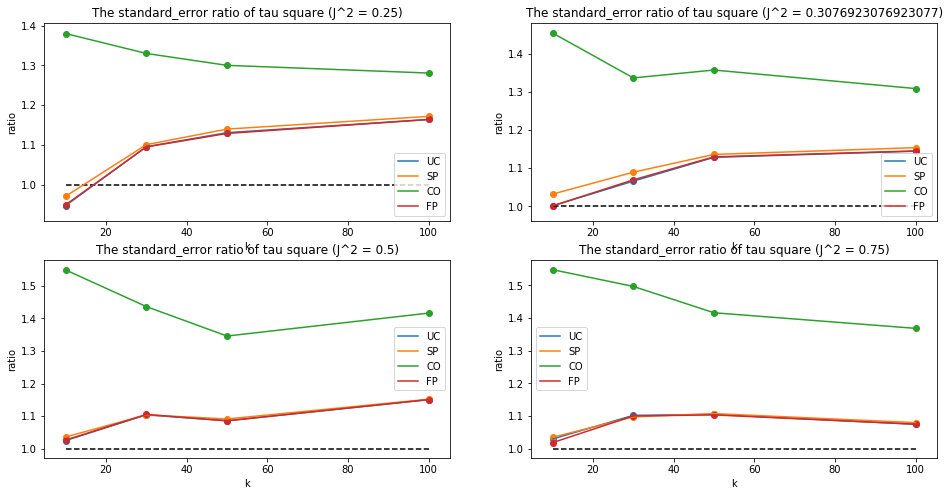

In [133]:
# plot of the standard_error ratio of tau square when J_sqaure = 0.25/0.31/0.5/0.75
fig = plt.figure(figsize=(16,8)) 
ax = fig.add_subplot(2,2,1)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.3076923076923077, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.5, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.75, handler=ax)

### plot of standard error ratio against k (using two different known sigma square)

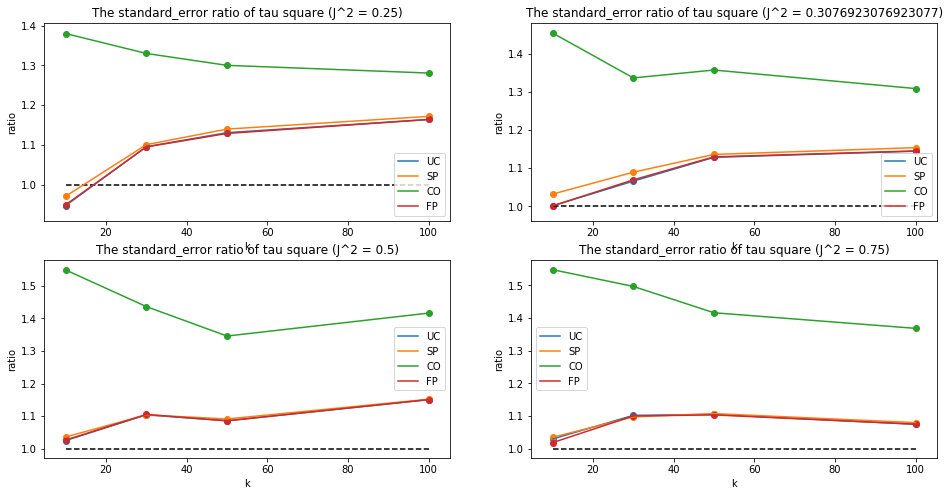

In [130]:
# plot of the standard_error ratio of tau square when J_sqaure = 0.25/0.31/0.5/0.75
fig = plt.figure(figsize=(16,8)) 
ax = fig.add_subplot(2,2,1)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.3076923076923077, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.5, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison(measurement='standard_error',x_axis='k', known_sigma_square = 'sample variance', k = 100, J_square = 0.75, handler=ax)

### plot of standard error ratio against J^2 (using two different known sigma square)

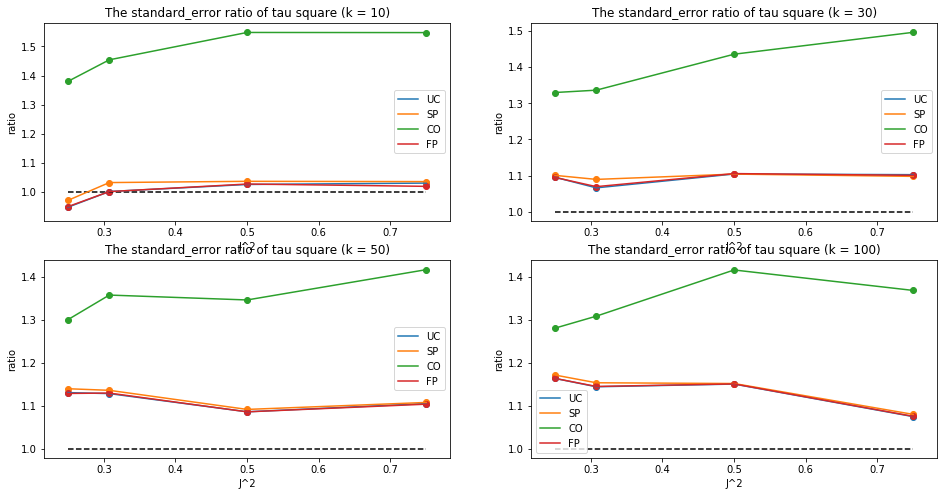

In [113]:
# plot of the standard_error ratio of tau square when J_sqaure = 0.25/0.31/0.5/0.75
fig = plt.figure(figsize=(16,8)) 
ax = fig.add_subplot(2,2,1)
plot_for_comparison(measurement='standard_error',x_axis='J^2', known_sigma_square = 'sample variance', k = 10, J_square = 0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison(measurement='standard_error',x_axis='J^2', known_sigma_square = 'sample variance', k = 30, J_square = 0.25, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison(measurement='standard_error',x_axis='J^2', known_sigma_square = 'sample variance', k = 50, J_square = 0.25, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison(measurement='standard_error',x_axis='J^2', known_sigma_square = 'sample variance', k = 100, J_square = 0.25, handler=ax)

# try multiple parameter settings
(i) Nmax/Nmin:  10, 25, 100, 250
(ii) Nmin: 10, 50

In [114]:
def array_generator_from_N(n_min,n_max,params,k=100):
    mu,sigma_square,tau_square = params
    sigma, tau = np.sqrt(sigma_square), np.sqrt(tau_square)
    half_k = int(k/2)
    # n_array consists of half of N equal to min + the remaining half of N equal to max
    n_array = np.array([n_min]*half_k + [n_max]*half_k)
    u_array = 1/n_array
    # x_i ~ N(mu,tau^2)
    xi_array = normal(mu,tau,k)
    # D_i ~ N(x_i, sigma^2*u_i)
    D_array = normal(xi_array,sigma*u_array**0.5,k)
    return u_array, D_array, xi_array

In [119]:
%%time
max_min_ratio_list = [2, 5, 10, 100]
n_min_list = [10, 50]
# k = 100 by default
n_replication = 1000

# (J^2,n_min,max_min_ratio,n_replication)
UC_unknown_sigma_N, UC_known_sigma_N, UC_known_sigma_N_chi = np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication))
SP_unknown_sigma_N, SP_known_sigma_N, SP_known_sigma_N_chi = np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication))
CO_unknown_sigma_N, CO_known_sigma_N, CO_known_sigma_N_chi = np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication))
FP_unknown_sigma_N, FP_known_sigma_N, FP_known_sigma_N_chi = np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication))

for r in range(n_replication):
    for params_idx, params in enumerate(parameter_constellation):
        
        for n_min_idx, n_min in enumerate(n_min_list):
            for max_min_idx, max_min_ratio in enumerate(max_min_ratio_list):
                n_max = n_min * max_min_ratio
                
                each_replication_array = array_generator_from_N(n_min,n_max,params)
                each_replication_u_array = each_replication_array[0]
                each_replication_D_array = each_replication_array[1]
                each_replication_xi_array = each_replication_array[2]
                # UC with unknown sigma
                UC_unknown_simulation = simulation_UC_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                UC_unknown_sigma_N[params_idx][n_min_idx][max_min_idx][r] = UC_unknown_simulation[1] #the estimated value of tau^2
                
                # UC with known sigma
                UC_known_simulation = simulation_UC_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                UC_known_sigma_N[params_idx][n_min_idx][max_min_idx][r] = UC_known_simulation[1] #the estimated value of tau^2
                UC_known_simulation_chi = simulation_UC_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                UC_known_sigma_N_chi[params_idx][n_min_idx][max_min_idx][r] = UC_known_simulation_chi[1] #the estimated value of tau^2
                
                # SP with unknown sigma
                SP_unknown_simulation = simulation_SP_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                SP_unknown_sigma_N[params_idx][n_min_idx][max_min_idx][r] = SP_unknown_simulation[1] #the estimated value of tau^2
                
                # UC with known sigma
                SP_known_simulation = simulation_SP_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                SP_known_sigma_N[params_idx][n_min_idx][max_min_idx][r] = SP_known_simulation[1] #the estimated value of tau^2
                SP_known_simulation_chi = simulation_SP_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                SP_known_sigma_N_chi[params_idx][n_min_idx][max_min_idx][r] = SP_known_simulation_chi[1] #the estimated value of tau^2
                
                # CO with unknown sigma
                CO_unknown_simulation = simulation_CO_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                CO_unknown_sigma_N[params_idx][n_min_idx][max_min_idx][r] = CO_unknown_simulation[1] #the estimated value of tau^2
                
                # CO with known sigma
                CO_known_simulation = simulation_CO_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                CO_known_sigma_N[params_idx][n_min_idx][max_min_idx][r] = CO_known_simulation[1] #the estimated value of tau^2
                CO_known_simulation_chi = simulation_CO_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                CO_known_sigma_N_chi[params_idx][n_min_idx][max_min_idx][r] = CO_known_simulation_chi[1] #the estimated value of tau^2
                
                # FP with unknown sigma
                FP_unknown_simulation = simulation_FP_unknown_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                FP_unknown_sigma_N[params_idx][n_min_idx][max_min_idx][r] = FP_unknown_simulation[1] #the estimated value of tau^2
                
                # FP with known sigma
                FP_known_simulation = simulation_FP_known_sigma(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                FP_known_sigma_N[params_idx][n_min_idx][max_min_idx][r] = FP_known_simulation[1] #the estimated value of tau^2
                FP_known_simulation_chi = simulation_FP_known_sigma_chi(each_replication_D_array,each_replication_u_array,each_replication_xi_array,params)
                FP_known_sigma_N_chi[params_idx][n_min_idx][max_min_idx][r] = FP_known_simulation_chi[1] #the estimated value of tau^2
                
                
                

CPU times: user 1h 9min 31s, sys: 4.97 s, total: 1h 9min 36s
Wall time: 1h 15min


In [120]:
def method_info_N(method_tau_square_array):
    # input: (4,2,4,n_replication) -> store the estimated value for tau^2
    # output: (4,2,4,3) 
    tau_square_mean = np.mean(method_tau_square_array,axis=3) #shape:(4,2,4)
    
    actual_tau_square_list = [params[2] for params in parameter_constellation]*2*4 # repeat [4,4,4,6] for 8 times
    actual_tau_square_array = np.array(actual_tau_square_list).reshape(4,2,4).T # convert into numpy array which has rows of 4/4/4/6 
                                                                                # along the first axis
    
    tau_square_bias = tau_square_mean - actual_tau_square_array
    tau_square_std = np.std(method_tau_square_array,axis=3)
    tau_square_mse = tau_square_mean**2 + tau_square_std**2
    
    return np.stack((tau_square_bias,tau_square_std,tau_square_mse),axis=3)

In [121]:
%%time
# summarize the simulation results into the form of [bias, standard_error, mse]
UC_unknown_sigma_info_N = method_info_N(UC_unknown_sigma_N)
UC_known_sigma_info_N = method_info_N(UC_known_sigma_N)
UC_known_sigma_info_N_chi = method_info_N(UC_known_sigma_N_chi)

SP_unknown_sigma_info_N = method_info_N(SP_unknown_sigma_N)
SP_known_sigma_info_N = method_info_N(SP_known_sigma_N)
SP_known_sigma_info_N_chi = method_info_N(SP_known_sigma_N_chi)

CO_unknown_sigma_info_N = method_info_N(CO_unknown_sigma_N)
CO_known_sigma_info_N = method_info_N(CO_known_sigma_N)
CO_known_sigma_info_N_chi = method_info_N(CO_known_sigma_N_chi)

FP_unknown_sigma_info_N = method_info_N(FP_unknown_sigma_N)
FP_known_sigma_info_N = method_info_N(FP_known_sigma_N)
FP_known_sigma_info_N_chi = method_info_N(FP_known_sigma_N_chi)

CPU times: user 3 ms, sys: 1.06 ms, total: 4.06 ms
Wall time: 2.97 ms


In [122]:
print(FP_known_sigma_info_N_chi.shape)

(4, 2, 4, 3)


In [123]:
# the bias/standard error/ mse ratio of tau^2 with unknown/known sigma
# [bias, standard error, mse]
UC_tau_square_ratio_N = UC_unknown_sigma_info_N/UC_known_sigma_info_N
SP_tau_square_ratio_N = SP_unknown_sigma_info_N/SP_known_sigma_info_N
CO_tau_square_ratio_N = CO_unknown_sigma_info_N/CO_known_sigma_info_N
FP_tau_square_ratio_N = FP_unknown_sigma_info_N/FP_known_sigma_info_N

UC_tau_square_ratio_N_chi = UC_unknown_sigma_info_N/UC_known_sigma_info_N_chi
SP_tau_square_ratio_N_chi = SP_unknown_sigma_info_N/SP_known_sigma_info_N_chi
CO_tau_square_ratio_N_chi = CO_unknown_sigma_info_N/CO_known_sigma_info_N_chi
FP_tau_square_ratio_N_chi = FP_unknown_sigma_info_N/FP_known_sigma_info_N_chi

In [136]:
def plot_for_comparison_N(measurement,x_axis, known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=plt):
    measurement_dict = {'bias':0, 'standard_error':1, 'mse':2}
    measurement_index = measurement_dict[measurement]
    
    J_square_index = J_square_list.index(J_square)
    
    # when comparing all the three methods with varying n_min, we fix max_min_ratio=10 by default
    if x_axis == 'n_min':
        x  = n_min_list
        max_min_ratio_index = max_min_ratio_list.index(max_min_ratio)
        if known_sigma_square == 'sample variance':
            UC_ratio = UC_tau_square_ratio_N[J_square_index,:,max_min_ratio_index,measurement_index]
            SP_ratio = SP_tau_square_ratio_N[J_square_index,:,max_min_ratio_index,measurement_index]
            CO_ratio = CO_tau_square_ratio_N[J_square_index,:,max_min_ratio_index,measurement_index]
            FP_ratio = FP_tau_square_ratio_N[J_square_index,:,max_min_ratio_index,measurement_index]
        else:
            UC_ratio = UC_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
            SP_ratio = SP_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
            CO_ratio = CO_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
            FP_ratio = FP_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,SP_ratio)
        handler.plot(x,SP_ratio,label='SP')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('n_min')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (n_max/n_min = '+str(max_min_ratio)+')')
        handler.hlines(y=1,xmin=min(n_min_list),xmax=max(n_min_list),linestyles='dashed')
    
    if x_axis == 'max_min_ratio':
        x = max_min_ratio_list
        n_min_index = n_min_list.index(n_min)
        if known_sigma_square == 'sample variance':
            UC_ratio = UC_tau_square_ratio_N[J_square_index,n_min_index,:,measurement_index]
            SP_ratio = SP_tau_square_ratio_N[J_square_index,n_min_index,:,measurement_index]
            CO_ratio = CO_tau_square_ratio_N[J_square_index,n_min_index,:,measurement_index]
            FP_ratio = FP_tau_square_ratio_N[J_square_index,n_min_index,:,measurement_index]
        else:
            UC_ratio = UC_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
            SP_ratio = SP_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
            CO_ratio = CO_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
            FP_ratio = FP_tau_square_ratio_N_chi[J_square_index,:,max_min_ratio_index,measurement_index]
        #print(FP_ratio)
        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,SP_ratio)
        handler.plot(x,SP_ratio,label='SP')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('n_max_min_ratio')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (n_min = '+str(n_min)+')')
        handler.hlines(y=1,xmin=min(max_min_ratio_list),xmax=max(max_min_ratio_list),linestyles='dashed')
    return

### Plot of standard_error ratio of tau square against n_min (using two different known sigma square)

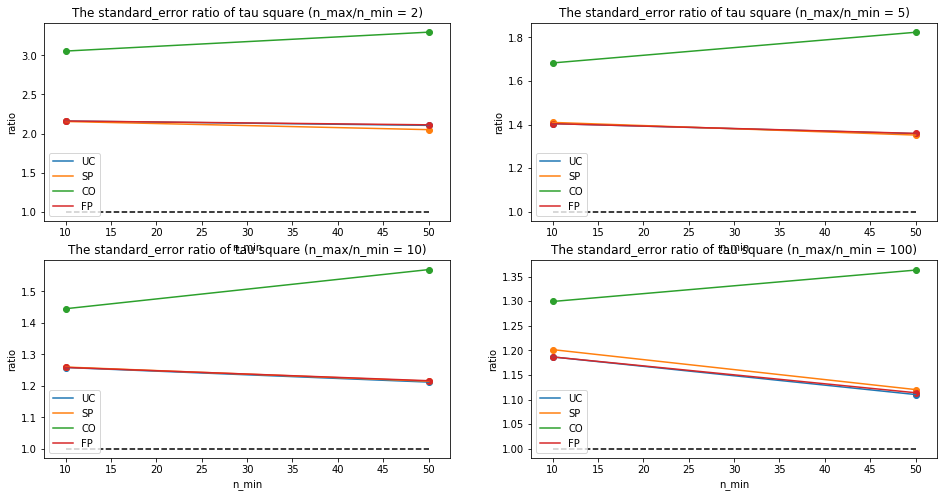

In [137]:
# plot of the standard_error ratio of tau square when max_min_ratio = 10/25/100/250
fig = plt.figure(figsize=(16,8)) ## setting over-all figure size (optional)
ax = fig.add_subplot(2,2,1)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 2, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 5, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 100, J_square=0.25, handler=ax)


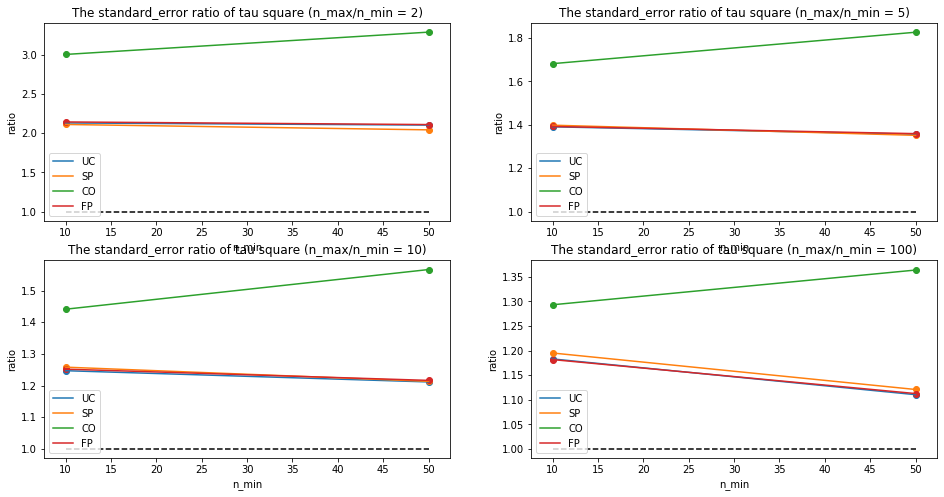

In [126]:
# plot of the standard_error ratio of tau square when max_min_ratio = 10/25/100/250
fig = plt.figure(figsize=(16,8)) ## setting over-all figure size (optional)
ax = fig.add_subplot(2,2,1)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'scaled chi square distributione', n_min = 10, max_min_ratio = 2, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'scaled chi square distribution', n_min = 10, max_min_ratio = 5, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'scaled chi square distribution', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', known_sigma_square = 'scaled chi square distribution', n_min = 10, max_min_ratio = 100, J_square=0.25, handler=ax)


### Plot of standard_error ratio of tau square against max_min_ratio (using two different known sigma square)

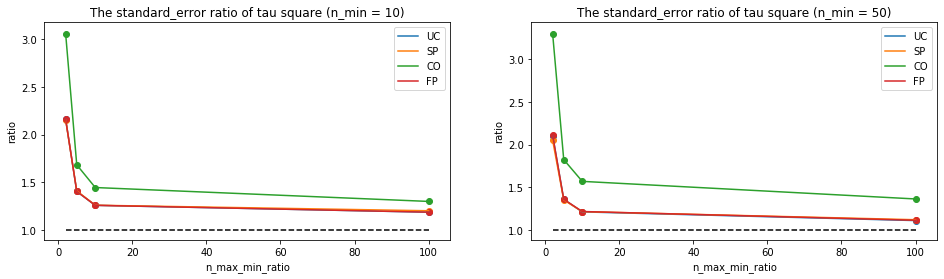

In [127]:
# plot of the standard_error ratio of tau square when n_min = 10/50
fig = plt.figure(figsize=(16,4)) ## setting over-all figure size (optional)
ax = fig.add_subplot(1,2,1)
plot_for_comparison_N(measurement='standard_error',x_axis='max_min_ratio', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=ax)
ax = fig.add_subplot(1,2,2)
plot_for_comparison_N(measurement='standard_error',x_axis='max_min_ratio', n_min = 50, max_min_ratio = 25, J_square=0.25, handler=ax)


### plot of the bias ratio

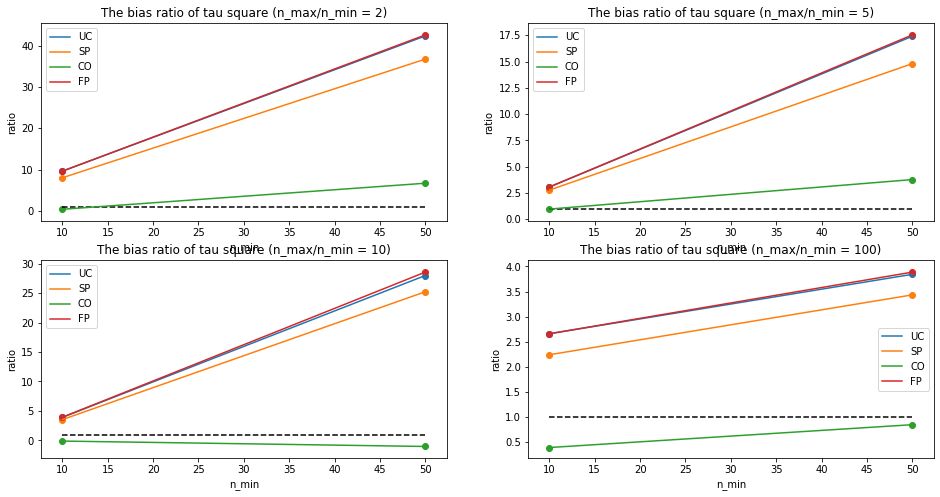

In [128]:
# plot of the standard_error ratio of tau square when max_min_ratio = 10/25/100/250
fig = plt.figure(figsize=(16,8)) ## setting over-all figure size (optional)
ax = fig.add_subplot(2,2,1)
plot_for_comparison_N(measurement='bias',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 2, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison_N(measurement='bias',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 5, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison_N(measurement='bias',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison_N(measurement='bias',x_axis='n_min', known_sigma_square = 'sample variance', n_min = 10, max_min_ratio = 100, J_square=0.25, handler=ax)


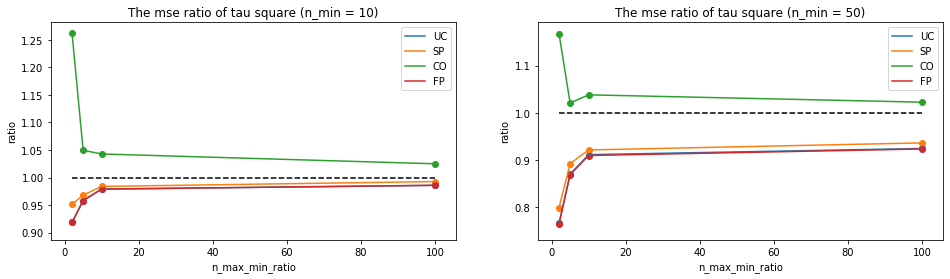

In [129]:
# plot of the standard_error ratio of tau square when n_min = 10/50
fig = plt.figure(figsize=(16,4)) ## setting over-all figure size (optional)
ax = fig.add_subplot(1,2,1)
plot_for_comparison_N(measurement='mse',x_axis='max_min_ratio', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=ax)
ax = fig.add_subplot(1,2,2)
plot_for_comparison_N(measurement='mse',x_axis='max_min_ratio', n_min = 50, max_min_ratio = 25, J_square=0.25, handler=ax)
